In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F

from sentence_transformers import SentenceTransformer, InputExample, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from datasets import load_dataset, Dataset

from tqdm import tqdm
import logging

from datetime import datetime

### My pooling method

In [2]:
from pooling import my_pooling
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Let's test and see that it runs

In [3]:
sentence_trans = SentenceTransformer('sentence-transformers/multi-qa-distilbert-cos-v1', device = device)
sentence_trans[1] = my_pooling(use_layernorm=True)
# model._first_module()
# sentence_trans

C:\Users\Dollcrusader\anaconda3\envs\ML_Final\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
dataset = load_dataset("mteb/cqadupstack-physics", "corpus")

In [5]:
index = dataset['corpus'].shape[0]
train_index = int(index*0.6)
dev_index = int(index*0.8)

index = int(index)
train_index = int(train_index)
dev_index = int(dev_index)

In [6]:
dataset_shuffled = dataset['corpus'].shuffle(seed=42)
train_samples = Dataset.from_dict(dataset_shuffled[0:train_index])
dev_samples = Dataset.from_dict(dataset_shuffled[train_index:dev_index])
test_samples = Dataset.from_dict(dataset_shuffled[dev_index:index])

In [7]:
from utils import shuffle_no_fixed_point

def InputData_tri(dataset):
    samples_set = []
    for title, text, rand_text in zip(dataset['title'], dataset['text'], shuffle_no_fixed_point(dataset['text'])):
        related = InputExample(texts=[title, text], label = 1.0)
        unrelated = InputExample(texts=[title, rand_text], label = 0.0)
        samples_set.append(related)
        samples_set.append(unrelated)
    return samples_set

In [8]:
train_samples_set = InputData_tri(train_samples)
test_samples_set = InputData_tri(test_samples)
dev_samples_set = InputData_tri(dev_samples)

In [9]:
train_batch_size = 12
num_epochs = 3
model_save_path = (
    "output/my_pooling_model" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)

train_dataloader = DataLoader(train_samples_set, shuffle=True, batch_size=train_batch_size)
train_loss = losses.AnglELoss(model=sentence_trans)

evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples_set[0:500], name="dev")

In [10]:
# Train the model
sentence_trans.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    evaluator=evaluator,
    evaluation_steps=100,
    warmup_steps=100,
    output_path=model_save_path,
)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3832 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3832 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3832 [00:00<?, ?it/s]

In [11]:
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples_set, name="physics-test")

In [12]:
test_evaluator(sentence_trans, output_path=model_save_path)

0.8630439917507787

In [13]:
scores = []
label = []
for data in test_samples_set:
    query_emb = sentence_trans.encode(data.texts[0])
    doc_emb = sentence_trans.encode(data.texts[1])
    scores.append(util.dot_score(query_emb, doc_emb)[0].cpu().tolist()[0])
    label.append(data.label)

In [14]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
label_np = np.array(label)
scores_np = np.array(scores)
auc = roc_auc_score(np.abs(label_np), np.abs(scores_np))
print("Auc:", auc)

Auc: 0.9980648790157383


In [15]:
threshold = 0.5
predicted_labels = (np.abs(scores_np) >= threshold).astype(int)

# Step 2: Compute the F1 score
f1 = f1_score(label_np, predicted_labels)

# Step 3: Compute the accuracy
accuracy = accuracy_score(label_np, predicted_labels)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

F1 Score: 0.9526276327448708
Accuracy: 0.9546581419624217


In [16]:
score = 0
i = 0
for l, s in zip(label_np, scores_np):
    if l == 1.0:
        score += s
        i += 1
print("Average score:", score/i)

Average score: 0.7107184630418139


In [23]:
import os 

In [24]:
torch.save(sentence_trans[1].state_dict(), os.path.join(model_save_path, "pytorch_model.bin"))

In [14]:
sentence_trans[1].ffn_512.layers[2]

SwiGLU(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=128, bias=True)
  (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)

In [13]:
scores = 0
query_emb = sentence_trans.encode(test_samples['title'])
doc_emb = sentence_trans.encode(test_samples['text'])
scores = util.dot_score(query_emb, doc_emb)

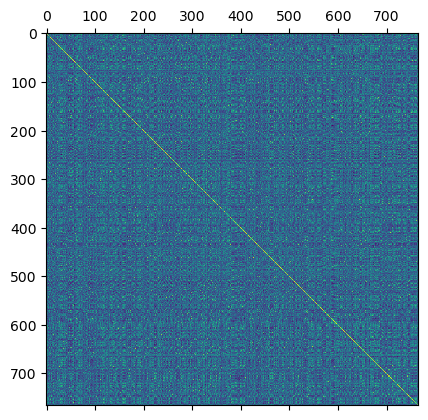

In [16]:
import matplotlib.pyplot as plt
plt.matshow(scores)

Parameter containing:
tensor([0.0089], device='cuda:0', requires_grad=True)